In [4]:
import os
import pandas as pd

from collections import Counter 
from wordcloud import WordCloud

from utils import preprocess

In [2]:
# read data
df = pd.read_json("../data/reviews_computers.json.gz", orient="records")
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df = df.sample(10000) # subset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 71926 to 51252
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   overall    10000 non-null  int64 
 1   vote       10000 non-null  int64 
 2   asin       10000 non-null  object
 3   text       10000 non-null  object
 4   summary    10000 non-null  object
 5   timestamp  10000 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 546.9+ KB


## Preprocessing

In [3]:
# apply preprocessing
df["preprocess"] = df["text"].apply(lambda x : preprocess(x))

/home/saiteki-kai/プロジェクト/進行中/data-analytics/venv/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [4]:
tokens = [word for doc in df["preprocess"] for sent in doc for word in sent]
c = Counter(tokens)

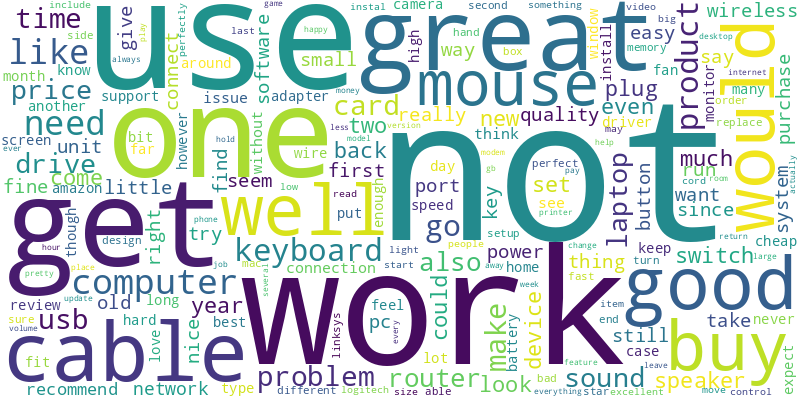

In [5]:
# generate the word cloud
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()

In [6]:
vocabulary = dict((e, i) for i, e in enumerate(set(tokens)))
print(len(vocabulary))

16970


## Generate data for ASUM

In [7]:
with open("../data/asum/WordList.txt", "w") as f:
  for word in vocabulary:
    f.write(f"{word}\n")

In [8]:
sentence_list = "../data/asum/BagOfSentences.txt"

if os.path.exists(sentence_list):
  os.remove(sentence_list)

with open(sentence_list, "a") as f:
  for doc in df["preprocess"]:
    f.write(f"{len(doc)}\n")
    for tokens in doc:
      indexes = " ".join([str(vocabulary[t]) for t in tokens])
      f.write(f"{indexes}\n")

In [10]:
from utils import asum

asum("../data/asum/", "../output/", "0.1", "0.001/0.1/0", "1/1", "10", iterations="500")

## Print Values

In [32]:
df = pd.read_csv(
    "../output/STO2-T10-S2(2)-A0.1-B0.001,0.1,0.0-G1.0,1.0-I500-ProbWords.csv"
)

def map_topic_sentiment(column_name):
  if ("Unnamed" in column_name):
    return None

  values = column_name.split("-")
  return {"sentiment": int(values[0][1]), "topic": int(values[1][1]), "colname": column_name }

columns = df.columns.map(map_topic_sentiment)

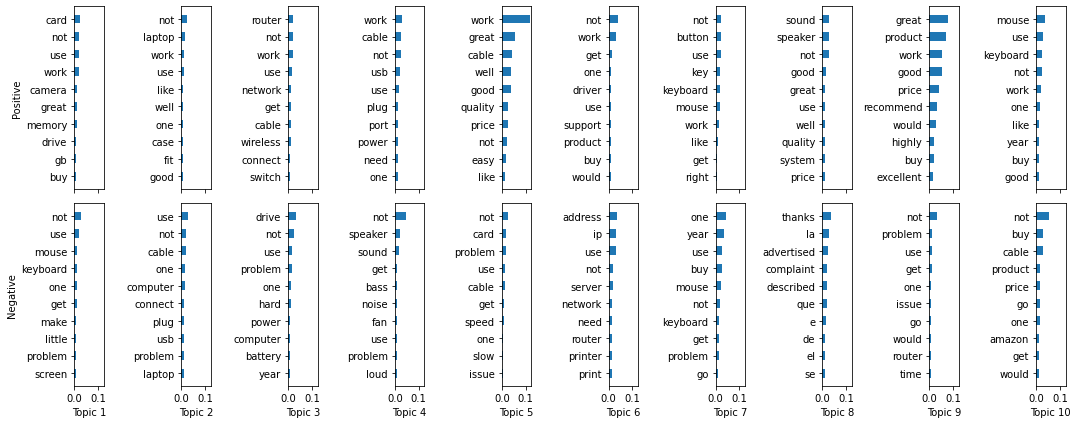

In [76]:
import matplotlib.pyplot as plt
import re

def get_word_weight(item):
  match = re.match("(\w+)\s+\((.*?)\)", item)
  word, weight = match.groups()
  return word, float(weight)

n_top_words = 10

fig, axes = plt.subplots(2, n_top_words, figsize=(15, 6), sharex=True)
axes = axes.flatten()

for idx, item in enumerate(columns):
  if item is None:
    continue
  
  ax = axes[idx]
  words = df[item["colname"]][:n_top_words]
  weights = list(map(list, zip(*words.map(get_word_weight))))

  weights = pd.DataFrame({"names": weights[0], "weights": weights[1]})
  weights.sort_values("weights", inplace=True)
  
  ax.barh(weights["names"], weights["weights"], height=0.5)
  
  if idx > n_top_words - 1:
    ax.set_xlabel(f"Topic {item['topic'] + 1}")

  if idx == 0 or idx == n_top_words:
    ax.set_ylabel("Positive" if item['sentiment'] == 0 else "Negative")
fig.tight_layout()